# Tutorial 2: Integrating all 12 DLPFC slices
This tutorial demonstrates STAligner's ablility to integrate 12 slices from three adult samples with four adjacent slices for each. The slices are sampled from human dorsolateral prefrontal cortex (DLPFC) and the processed data can be downloaded from https://drive.google.com/drive/folders/1pHJy2cB9BKqc3ny9IpvVhiw_8ukJMzPW?usp=share_link.

## Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import STAligner

# the location of R (used for the mclust clustering)
import os
#os.environ['R_HOME'] = "/home/xzhou/anaconda3/envs/PyG/lib/R"
#os.environ['R_USER'] = "/home/xzhou/anaconda3/envs/PyG/lib/python3.8/site-packages/rpy2"
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri


import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.sparse as sp
import scipy.linalg

import torch
used_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Load Data

In [ ]:
Batch_list = []
adj_list = []
section_ids = ['151673', '151674', '151675', '151676',
               '151507', '151508', '151509', '151510',
               '151669', '151670','151671', '151672']
print(section_ids)

for section_id in section_ids:
    print(section_id)
    input_dir = os.path.join('../../../data/DLPFC', section_id)
    adata = sc.read_visium(path=input_dir, count_file=section_id + '_filtered_feature_bc_matrix.h5', load_images=True)
    adata.var_names_make_unique(join="++")    

    # read the annotation
    Ann_df = pd.read_csv(os.path.join(input_dir, 'manual_annotations.txt'), sep='\t', header=None, index_col=0)
    Ann_df.columns = ['Ground Truth']
    Ann_df[Ann_df.isna()] = "unknown"
    adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth'].astype('category')
    
    # make spot name unique
    adata.obs_names = [x + '_' + section_id for x in adata.obs_names]

    STAligner.Cal_Spatial_Net(adata, rad_cutoff=150)

    ## Normalization
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=10000) #ensure enough common HVGs in the combined matrix
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata = adata[:, adata.var['highly_variable']]
    
    adj_list.append(adata.uns['adj'])
    Batch_list.append(adata)

['151673', '151674', '151675', '151676', '151507', '151508', '151509', '151510', '151669', '151670', '151671', '151672']
151673


## Concat the scanpy objects for multiple slices

In [4]:
adata_concat = ad.concat(Batch_list, label="slice_name", keys=section_ids)
adata_concat.obs['Ground Truth'] = adata_concat.obs['Ground Truth'].astype('category')
adata_concat.obs["batch_name"] = adata_concat.obs["slice_name"].astype('category')
print('adata_concat.shape: ', adata_concat.shape)

# combine silce names into sample name
new_batch_1 = adata_concat.obs["slice_name"].isin(['151673', '151674', '151675', '151676'])
new_batch_2 = adata_concat.obs["slice_name"].isin(['151507', '151508', '151509', '151510'])
new_batch_3 = adata_concat.obs["slice_name"].isin(['151669', '151670', '151671', '151672'])
adata_concat.obs["sample_name"] = list(sum(new_batch_1)*['Sample 1'])+list(sum(new_batch_2)*['Sample 2'])+list(sum(new_batch_3)*['Sample 3'])
adata_concat.obs["sample_name"] = adata_concat.obs["sample_name"].astype('category')
adata_concat.obs["batch_name"] = adata_concat.obs["sample_name"].copy()

adata_concat.shape:  (47681, 800)


## Concat the spatial network for multiple slices

In [5]:
adj_concat = np.asarray(adj_list[0].todense())
for batch_id in range(1,len(section_ids)):
    adj_concat = scipy.linalg.block_diag(adj_concat, np.asarray(adj_list[batch_id].todense()))
adata_concat.uns['edgeList'] = np.nonzero(adj_concat)

## Running STAligner

In [6]:
%%time
# Important parameter:
# "iter_comb" is used to specify the order of integration
# "margin" is used to control the intensity/weight of batch correction
adata_concat = STAligner.train_STAligner(adata_concat, iter_comb = None, verbose=True, device=used_device, margin=1.0)

STAligner(
  (conv1): GATConv(800, 512, heads=1)
  (conv2): GATConv(512, 30, heads=1)
  (conv3): GATConv(30, 512, heads=1)
  (conv4): GATConv(512, 800, heads=1)
)
Pretrain with STAGATE...


100%|██████████| 500/500 [00:16<00:00, 30.63it/s]


Train with STAligner...


  0%|          | 0/500 [00:00<?, ?it/s]

Update spot triplets at epoch 500


 20%|██        | 100/500 [00:19<00:14, 28.21it/s]

Update spot triplets at epoch 600


 40%|████      | 200/500 [00:40<00:10, 28.87it/s]

Update spot triplets at epoch 700


 60%|██████    | 300/500 [01:01<00:06, 28.90it/s]

Update spot triplets at epoch 800


 80%|████████  | 400/500 [01:23<00:03, 28.90it/s]

Update spot triplets at epoch 900


100%|██████████| 500/500 [01:45<00:00,  4.72it/s]


CPU times: total: 4min 1s
Wall time: 2min 2s


## Visualization

In [7]:
STAligner.mclust_R(adata_concat, num_cluster=7, used_obsm='STAligner')
adata_concat = adata_concat[adata_concat.obs['Ground Truth']!='unknown']

from sklearn.metrics import adjusted_rand_score as ari_score
print('mclust, ARI = %01.3f' % ari_score(adata_concat.obs['Ground Truth'], adata_concat.obs['mclust']))

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
mclust, ARI = 0.391


## Visualization

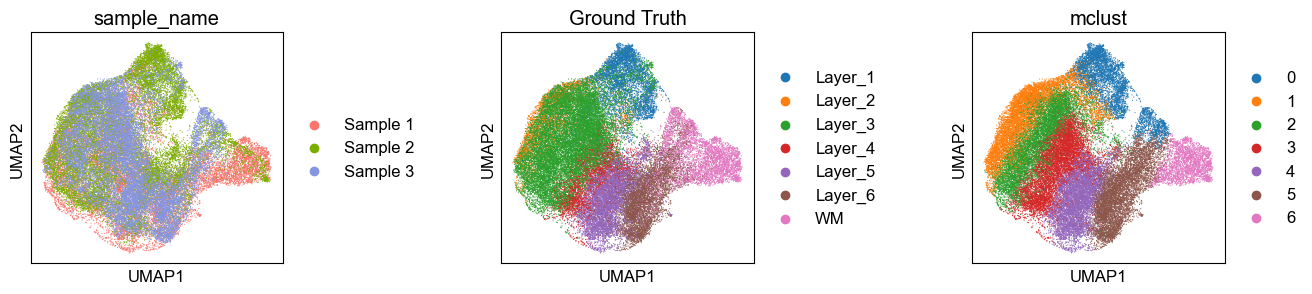

In [8]:
sc.pp.neighbors(adata_concat, use_rep='STAligner', random_state=666)
sc.tl.umap(adata_concat, random_state=666)

sample_id = ['Sample 1', 'Sample 2', 'Sample 3']
sample_color = ['#f8766d', '#7cae00', '#8595e1']
sample_color_dict = dict(zip(sample_id, sample_color))
adata_concat.uns['sample_name_colors'] = [sample_color_dict[x] for x in adata_concat.obs.sample_name.cat.categories]

adata_concat.obs['mclust'] = pd.Series(STAligner.match_cluster_labels(adata_concat.obs['Ground Truth'], adata_concat.obs['mclust'].values),
                                         index=adata_concat.obs.index, dtype='category')


import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams['font.size'] = 12
sc.pl.umap(adata_concat,color=['sample_name','Ground Truth','mclust'],ncols=3,wspace=0.7,show=True)